# Dog Breed Application

* [1](#step1): Loading the datasets
* [2](#step2): Human detection
* [3](#step3): Dog detection
* [4](#step4): Classify dog breeds
* [5](#step5): Writing the Application algorithm
* [6](#step6): Testing the application

<a id='step1'></a>
## 1: Loading the datasets

#### Importing the dog dataset 

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np
from glob import glob

#Using the load_files function from the scikit-learn library to
#populate the following variables
#train, valid and test_files are numpy arrays containing file paths to images
#train, valid and test_targets are numpy arrays containing onehot-encoded labels
#dog_names is a list os strings containing the dog breed names
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133) #133 breeds
    return dog_files, dog_targets

train_files, train_targets = load_dataset('dogImages/train')
test_files, test_targets = load_dataset('dogImages/test')
valid_files, valid_targets = load_dataset('dogImages/valid')

dog_names = [item[20:-1] for item in sorted(glob('dogImages/train/*/'))]

#print some statistics
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


#### Importing the humans dataset 

In [41]:
import random
random.seed(8675309)

human_files = np.array(glob('lfw/*/*'))
random.shuffle(human_files)

#print some statistics
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


<a id='step2'></a>
## 2: Human detection

#### Face detection with opencv Haar feature-based cascade  

In [45]:
import cv2

#load the classifier into a variable
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

#Given an image path this function whil return true if a face was
#detected in the image and false otherwise
def HaarCascade_faceDetector(img_path):
        img = cv2.imread(img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        faces = face_cascade.detectMultiScale(gray_img)
        return len(faces) > 0

#### Face detection with opencv deep learning approach 

#### Now it's time to test the two approaches 

In [46]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

count_humans = 0
count_dogs = 0

for path in human_files_short:
    if(HaarCascade_faceDetector(path)):
        count_humans += 1

for path in dog_files_short:
    if(HaarCascade_faceDetector(path)):
        count_dogs += 1

print('Testing in the first 100 images of humans and dogs')
print('%d human faces were detected in the first 100 images of humans' % count_humans)
print('%d human faces were detected in the first 100 images of dogs' % count_dogs)

Testing in the first 100 images of humans and dogs
98 human faces were detected in the first 100 images of humans
10 human faces were detected in the first 100 images of dogs


<a id='step3'></a>
## 3: Detecting dogs 

#### Using ResNet50 trained in the ImageNet dataset to detect if there is a dog in the image

In [24]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from tqdm import tqdm

ResNet50_model = ResNet50(weights='imagenet')

#Keras CNNs require a 4D tensor as input in the form
#      (nb_samples, rows, columns, channels)
#So we use the path_to_tensor function to convert the image into (1, 224, 224, 3)
#And the paths_to_tensor function to make all tensors together (nb_samples, 224, 224, 3)

def path_to_tensor(img_path):
    #read and resize the image
    img = image.load_img(img_path, target_size=(224,224))
    #convert image to a 3D tensor with shape (224, 224, 3)
    tensor_3d = image.img_to_array(img)
    #convert the 3D tensor to a 4D tensor with shape (1, 224, 224, 3)
    return np.expand_dims(tensor_3d, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

#Getting the 4D tensor ready to the ResNet50 requires some additional processing
#like converting the RGB image to BGR and some normalization steps that
#the preprecess function from keras will make for us
def ResNet50_predict_labels(img_path):
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

#now we can create the dog detector function
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

#### testing the dog detector 

In [7]:
count_humans = 0
count_dogs = 0

for path in human_files_short:
    if(dog_detector(path)):
        count_humans += 1

for path in dog_files_short:
    if(dog_detector(path)):
        count_dogs += 1

print('dogs found in Human dataset:', count_humans)
print('dogs found in dogs dataset:', count_dogs)

dogs found in Human dataset: 1
dogs found in dogs dataset: 100


<a id='step4'></a>
## 4: Creating the CNNs to classify Dog Breeds 

#### 4.1 Creating a CNN from scratch in Keras 

In [8]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:18<00:00, 44.64it/s]


In [13]:
#defining the architecture
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, padding='valid', activation='relu', input_shape=(224, 224, 3)))
model.add(Conv2D(filters=64, kernel_size=3, padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='valid'))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(133, activation='softmax'))
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 774400)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               99123328  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
den

In [10]:
#compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
#Training
from keras.callbacks import ModelCheckpoint

epochs = 5
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.keras.hdf5',
                              verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets,
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/5
6680/6680 [==============================] - 1729s - loss: 15.9192 - acc: 0.0102 - val_loss: 15.9444 - val_acc: 0.0108
Epoch 2/5
6680/6680 [==============================] - 1639s - loss: 5.4890 - acc: 0.0136 - val_loss: 4.7857 - val_acc: 0.0204
Epoch 3/5
6680/6680 [==============================] - 1596s - loss: 4.2045 - acc: 0.1265 - val_loss: 4.7816 - val_acc: 0.0371
Epoch 4/5
6680/6680 [==============================] - 1598s - loss: 1.2432 - acc: 0.7302 - val_loss: 7.2074 - val_acc: 0.0407
Epoch 5/5
6680/6680 [==============================] - 1610s - loss: 0.2695 - acc: 0.9533 - val_loss: 9.2935 - val_acc: 0.0407


In [12]:
#Load the best model and test it
model.load_weights('saved_models/weights.best.from_scratch.keras.hdf5')

dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 4.7847%


#### 4.2 Using transfer learning to classify dogs 

In [7]:
#Reading the bottleneck features of the Resnet to use to transfer learning
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_RESNET50 = bottleneck_features['train']
test_RESNET50 = bottleneck_features['test']
valid_RESNET50 = bottleneck_features['valid']

In [15]:
#print(train_RESNET50.shape)
#train_RESNET50.shape = (6680, 1, 1, 2048)
#To pass to our fully conected NN we will need only the shape of the flatten
#vector and not the number of samples(6680)
model_RNT = Sequential()
model_RNT.add(GlobalAveragePooling2D(input_shape=train_RESNET50.shape[1:]))
model_RNT.add(Dense(256, activation='relu'))
model_RNT.add(Dropout(0.2))
model_RNT.add(Dense(133, activation='softmax'))
model_RNT.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 133)               34181     
Total params: 558,725.0
Trainable params: 558,725.0
Non-trainable params: 0.0
_________________________________________________________________


In [17]:
#compiling the model
model_RNT.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.RESNET50.sgd.hdg5')
model_RNT.fit(train_RESNET50, train_targets,
         validation_data=(valid_RESNET50, valid_targets),
         epochs=40, batch_size=20, verbose=1, callbacks=[checkpointer])

Train on 6680 samples, validate on 835 samples
Epoch 1/40
6680/6680 [==============================] - 2s - loss: 1.0894 - acc: 0.7127 - val_loss: 0.9106 - val_acc: 0.7545
Epoch 2/40
6680/6680 [==============================] - 1s - loss: 0.8160 - acc: 0.7780 - val_loss: 0.7697 - val_acc: 0.7868
Epoch 3/40
6680/6680 [==============================] - 2s - loss: 0.6585 - acc: 0.8181 - val_loss: 0.6972 - val_acc: 0.8036
Epoch 4/40
6680/6680 [==============================] - 1s - loss: 0.5774 - acc: 0.8434 - val_loss: 0.6518 - val_acc: 0.8012
Epoch 5/40
6680/6680 [==============================] - 2s - loss: 0.5020 - acc: 0.8537 - val_loss: 0.6203 - val_acc: 0.8168
Epoch 6/40
6680/6680 [==============================] - 2s - loss: 0.4376 - acc: 0.8775 - val_loss: 0.6033 - val_acc: 0.8240
Epoch 7/40
6680/6680 [==============================] - 2s - loss: 0.3965 - acc: 0.8931 - val_loss: 0.5825 - val_acc: 0.8251
Epoch 8/40
6680/6680 [==============================] - 2s - loss: 0.3628 - ac

In [22]:
#Load the best model
model_RNT.load_weights('saved_models/weights.best.RESNET50.sgd.hdg5')

In [23]:
RESNET50_predictions = [np.argmax(model_RNT.predict(np.expand_dims(feature, axis=0))) for feature in test_RESNET50]

test_accuracy = 100*np.sum(np.array(RESNET50_predictions)==np.argmax(test_targets, axis=1))/len(RESNET50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 84.6890%


#### Defining the function to predict a breed of a dog 

In [26]:
from extract_bottleneck_features import *

def RESNET50_predict_breed(img_path):
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    predicted_vector = model_RNT.predict(bottleneck_feature)
    return dog_names[np.argmax(predicted_vector)]

<a id='step5'></a>
## 5: Writing the algorithm 

In [48]:
def DogBreedApplication(img_path):
    #check if there is a dog in the image
    if(dog_detector(img_path)):
        breed = RESNET50_predict_breed(img_path)
        return 'The predicted breed of this dog is: ' + breed
    elif(HaarCascade_faceDetector(img_path)):
        human_breed = RESNET50_predict_breed(img_path)
        return 'This humans look like a: ' + human_breed
    else:
        return 'Dog nor human detected'

<a id='step6'></a>
## 6: Testing

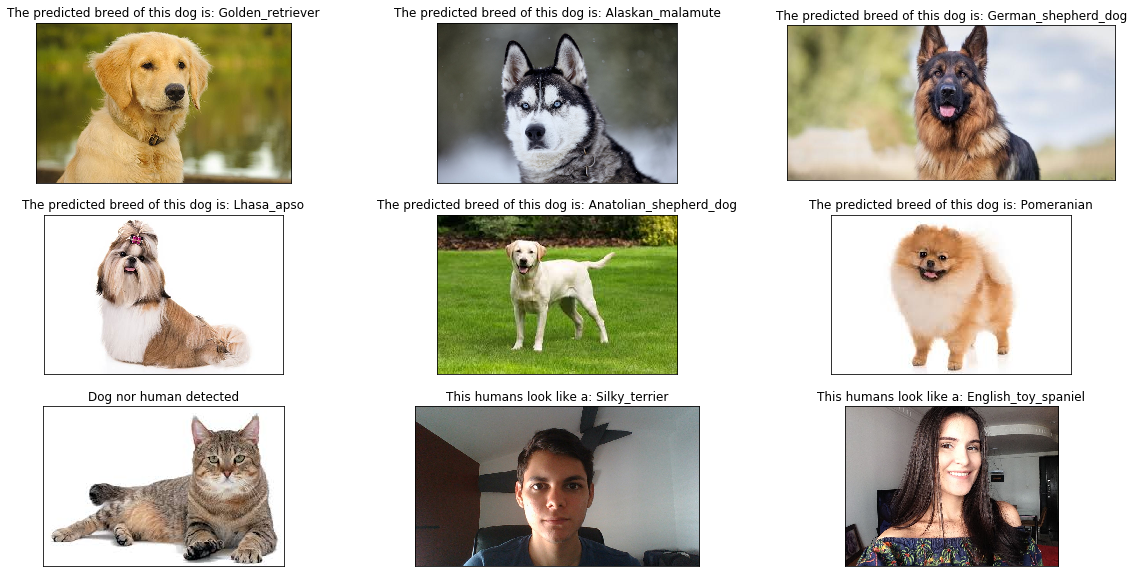

In [49]:
import cv2
import matplotlib.pyplot as plt

paths = []

paths.append('images_test_final_app/golden.jpg')
paths.append('images_test_final_app/husky.jpg')
paths.append('images_test_final_app/pastor_alemao.jpg')
paths.append('images_test_final_app/Shih-Tzu.jpg')
paths.append('images_test_final_app/labrador.jpeg')
paths.append('images_test_final_app/pomeranian.jpeg')
paths.append('images_test_final_app/cat.jpeg')
paths.append('images_test_final_app/me.jpg')
paths.append('images_test_final_app/lari_3.jpeg')

fig = plt.figure(figsize=(20,10))
i = 0
for filepath in paths:
    img = cv2.imread(filepath)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
    ax.imshow(cv_rgb)
    ax.set_title(DogBreedApplication(filepath))
    i += 1